In [1]:
import pandas as pd
import numpy as np
from datetime import date
import statsmodels.api as sm
import seaborn as sns
from glob import glob
import copy
from statsmodels.stats.multitest import fdrcorrection as fdrcorr
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

today=str(date.today())

In [2]:
# Data paths
candpath = '/gpfs/milgram/pi/gee_dylan/candlab'
datapath = candpath + '/analyses/shapes/dwi/data'

# Import subjects
subs = ri_sublist = pd.read_csv(datapath + '/../subjectlist_preDiss_motion0.75_n107_2021-03-29.csv', names = ['index', 'Subject'], header = 0)
print('Number Subject: {}'.format(len(subs)))

#DTI Column Names
colnames_dti = ['AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CC_1', 'CC_2', 'CC_3',
       'CC_4', 'CC_5', 'CC_6', 'CC_7', 'CG_left', 'CG_right', 'CST_left',
       'CST_right', 'FPT_left', 'FPT_right', 'ICP_left', 'ICP_right',
       'IFO_left', 'IFO_right', 'ILF_left', 'ILF_right', 'MCP', 'OR_left',
       'OR_right', 'POPT_left', 'POPT_right', 'SCP_left', 'SCP_right',
       'SLF_I_left', 'SLF_I_right', 'SLF_II_left', 'SLF_II_right',
       'SLF_III_left', 'SLF_III_right', 'STR_left', 'STR_right', 'UF_left',
       'UF_right', 'T_PREM_left', 'T_PREM_right', 'T_PAR_left', 'T_PAR_right',
       'T_OCC_left', 'T_OCC_right', 'ST_FO_left', 'ST_FO_right',
       'ST_PREM_left', 'ST_PREM_right']

Number Subject: 106


### Data Cleaning

In [17]:
# Import demographic data
demo_raw = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Demographic_Info.csv', 
                   header = 0).rename(columns = {'subj_id':'Subject', 'branch_a_sex':'sex'})
demo = demo_raw[['Subject', 'sex', 'asr_age']].set_index('Subject')

diag = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/DiagnosticStatus.csv', 
                   header = 0).rename(columns = {'record_id':'Subject', 'cc_group':'diagnostic_group'})
diag_only = diag[['Subject', 'diagnostic_group']].set_index('Subject')

demo_data = pd.concat([demo, diag_only], axis=1).reset_index().rename(columns={'index':'Subject'})

#Import RI data (Wide)
ri1 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_WIDE_threat_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri1.columns = 'threat_' + ri1.columns
ri1 = ri1.rename(columns = {'threat_Subject':'Subject'}).set_index('Subject')

ri2 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_WIDE_dep_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri2.columns = 'dep_' + ri2.columns
ri2 = ri2.rename(columns = {'dep_Subject':'Subject'}).set_index('Subject')

ri3 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_WIDE_any_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri3.columns = 'all_' + ri3.columns
ri3 = ri3.rename(columns = {'all_Subject':'Subject'}).set_index('Subject')

#Concatenate RI data
ri_data = pd.concat([ri1, ri2, ri3], axis=1).reset_index().rename(columns={'index':'Subject'})
print("RI Data Size: {}".format(ri_data.shape))

RI Data Size: (142, 256)


In [18]:
# Keep only average severity ratings
r1_thr = ri1.reset_index().loc[:,"Subject":"threat_avg_sev.29"]
r2_thr = ri2.reset_index().loc[:,"Subject":"dep_avg_sev.23"]
r3_thr = ri3.reset_index().loc[:,"Subject":"all_avg_sev.29"]

ri_data_avg1 = pd.merge(r1_thr, r2_thr, on='Subject', how = 'outer')
# ri_data_avg2 = pd.merge(ri_|data_avg1, r3_thr, on='Subject', how = 'outer')

# Keep only threat and dep
ri_data_avg = ri_data_avg1
print("Threat or Dep endorsements only size: {}".format(ri_data_avg.shape))

Threat or Dep endorsements only size: (115, 55)


In [5]:
#Import RI data (long)
ri4 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_threat_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri4.columns = 'threat_' + ri4.columns
ri4 = ri4.rename(columns = {'threat_Subject':'Subject'})

ri5 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_dep_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri5.columns = 'dep_' + ri5.columns
ri5 = ri5.rename(columns = {'dep_Subject':'Subject'})

ri6 = pd.read_csv(datapath + '/../Flux_Analysis/Behavioral/Cleaned_all_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri6.columns = 'all_' + ri6.columns
ri6 = ri6.rename(columns = {'all_Subject':'Subject'})

In [20]:
#Merge data together
m1 = pd.merge(subs['Subject'], demo_data, how = 'left', on='Subject').dropna(how = 'any', axis=0) #Drop pts without age/sex/dx
m2 = pd.merge(m1, ri_data, how = 'left', on='Subject')

bx_df = m2
bx_df.shape
print(bx_df.shape)

long_thr_df = pd.merge(m1, ri4, how = 'inner', on = 'Subject')
long_dep_df = pd.merge(m1, ri5, how = 'inner', on = 'Subject')
long_all_df = pd.merge(m1, ri6, how = 'inner', on = 'Subject')

#Write to csv
# bx_df.to_csv(datapath + '/Merged_RI_Behavioral_Sample_n{}_{}.csv'.format(len(bx_df), today))
# ri_data_avg.to_csv(datapath + '/RI_data_ThreatDepOnly_n{}_{}.csv'.format(len(ri_data_avg), today))
# demo_data.to_csv(datapath + '/DemographicDataOnly_n{}_{}.csv'.format(len(demo_data), today))

(87, 259)


In [7]:
def compute_tract_means(sub_df):
    peak_output = np.ones((len(sub_df), 50), dtype='object')
    fa_output = np.ones((len(sub_df), 50), dtype='object')
    
    for i in range(0, len(sub_df)):
        subx = sub_df['Subject'][i]
        sub = 'sub-' + subx
        fa_files = glob(datapath + '/tract_output/{}/Tractometry_TensorMetrics_{}.csv'.format(sub, sub))
        peak_files = glob(datapath + '/tract_output/{}/Tractometry_PeakLength_{}.csv'.format(sub, sub))

        peak_rawdata = pd.read_csv(peak_files[0], header = 0, sep = ';')
        fa_rawdata = pd.read_csv(fa_files[0], header = 0, sep = ';')

        column_names = peak_rawdata.columns
        peak_means = peak_rawdata.mean(axis=0)
        fa_means = fa_rawdata.mean(axis=0)

        peak_output[i,:] = peak_means
        fa_output[i,:] = fa_means
            
    output_peak_df = pd.concat([sub_df['Subject'], pd.DataFrame(peak_output, columns = column_names)], axis=1)
    output_fa_df = pd.concat([sub_df['Subject'], pd.DataFrame(fa_output, columns = column_names)], axis=1)
    
    return output_peak_df, output_fa_df

In [8]:
def extract_uf(sub_df):
    l_output = np.ones((len(sub_df), 98), dtype='object')
    r_output = np.ones((len(sub_df), 98), dtype='object')
    for i in range(0, len(sub_df)):
        subx = sub_df['Subject'][i]
        sub = 'sub-' + subx
        try:
            files = glob(datapath + '/tract_output/{}/Tractometry_TensorMetrics_{}.csv'.format(sub, sub))
            rawdata = pd.read_csv(files[0], header = 0, sep = ';')
            luf_data = rawdata['UF_left']
            ruf_data = rawdata['UF_right']
            l_output[i, :] = luf_data
            r_output[i, :] = ruf_data
        except:
            print("No output for {}".format(sub))
            l_output[i, :] = np.nan
            r_output[i, :] = np.nan
    l_output_df = pd.concat([sub_df['Subject'], pd.DataFrame(l_output)], axis=1)
    r_output_df = pd.concat([sub_df['Subject'], pd.DataFrame(r_output)], axis=1)
    return l_output_df, r_output_df

luf_df, ruf_df = extract_uf(bx_df)

In [9]:
# uf_df = pd.merge(luf_df, ruf_df, on='Subject')
# uf_df.to_csv('~/AH_Thesis_DTI_FA_{}.csv'.format(today))

In [10]:
def regress_covariates(dti_df, behav_df):
    regressed_output = np.ones((len(dti_df), len(dti_df.columns)-1))
    regressors = behav_df[['sex', 'asr_age']]
    regressors['sex'] = regressors['sex'].astype('category')
    regressors['asr_age'] = regressors['asr_age'].astype(float)
#     regressors['diagnostic_group'] = regressors['diagnostic_group'].astype('category')
    regressors = sm.add_constant(regressors) #Add intercept for OLS regression per https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
    f_regressors = regressors.to_numpy()
    for i in range(0, len(dti_df.columns)-1):
        #Set variables and ensure dtype
        dti_col = dti_df.drop('Subject', axis=1).to_numpy()[:,i].astype(float)
        model = sm.OLS(endog = dti_col, exog=f_regressors)
        result = model.fit()
        regressed_output[:,i] = result.resid
    
    return regressed_output

In [13]:
fa_df

,Subject,AF_left,AF_right,ATR_left,ATR_right,CC_1,CC_2,CC_3,CC_4,CC_5,CC_6,CC_7,CG_left,CG_right,CST_left,CST_right,FPT_left,FPT_right,ICP_left,ICP_right,IFO_left,IFO_right,ILF_left,ILF_right,MCP,OR_left,OR_right,POPT_left,POPT_right,SCP_left,SCP_right,SLF_I_left,SLF_I_right,SLF_II_left,SLF_II_right,SLF_III_left,SLF_III_right,STR_left,STR_right,UF_left,UF_right,T_PREM_left,T_PREM_right,T_PAR_left,T_PAR_right,T_OCC_left,T_OCC_right,ST_FO_left,ST_FO_right,ST_PREM_left,ST_PREM_right
0,A217,0.468963,0.461633,0.389679,0.417515,0.491955,0.515585,0.529172,0.551143,0.562383,0.562578,0.611376,0.457272,0.469396,0.598744,0.563699,0.50373,0.522753,0.392174,0.417686,0.455425,0.489264,0.487238,0.457646,0.511925,0.45038,0.45149,0.601379,0.581255,0.445319,0.435261,0.496612,0.519913,0.450483,0.4741,0.468927,0.449593,0.50536,0.484358,0.407916,0.439578,0.458762,0.441596,0.53073,0.515384,0.452087,0.464919,0.407723,0.425993,0.426287,0.434601
1,A222,0.489558,0.452553,0.451614,0.446098,0.52672,0.535175,0.540944,0.562155,0.553998,0.547171,0.545471,0.417078,0.43093,0.591601,0.568663,0.565113,0.539151,0.430386,0.433853,0.484355,0.484962,0.466876,0.457851,0.487253,0.499654,0.507591,0.574457,0.578123,0.453371,0.443098,0.482047,0.496835,0.483797,0.495138,0.470902,0.457696,0.492876,0.477945,0.427234,0.431092,0.497244,0.455738,0.514017,0.497762,0.503734,0.50915,0.446618,0.44881,0.409958,0.435302
2,A223,0.457346,0.481592,0.411065,0.412823,0.524249,0.527781,0.56074,0.565387,0.54283,0.546547,0.58929,0.465431,0.466349,0.565681,0.551067,0.513953,0.50358,0.41631,0.420126,0.495114,0.490775,0.490242,0.493738,0.479832,0.493557,0.498446,0.538839,0.531757,0.44936,0.44264,0.486707,0.510947,0.430168,0.468716,0.474926,0.464262,0.492035,0.456042,0.441122,0.443644,0.447899,0.426514,0.494439,0.482133,0.495037,0.496586,0.414226,0.44346,0.398844,0.41443
3,A225,0.444737,0.454042,0.395934,0.4078,0.491396,0.515098,0.525785,0.539193,0.577194,0.578721,0.641262,0.493755,0.426354,0.0,0.546285,0.484827,0.522896,0.379121,0.408479,0.440372,0.441169,0.450232,0.442817,0.506221,0.452881,0.472672,0.561147,0.544846,0.457495,0.434554,0.463724,0.491054,0.479617,0.491026,0.439131,0.431069,0.504882,0.488211,0.415551,0.434419,0.461518,0.491342,0.509415,0.502602,0.437382,0.496046,0.413949,0.427909,0.386759,0.417997
4,A228,0.478088,0.453747,0.437857,0.445976,0.547128,0.55052,0.568068,0.575193,0.561112,0.579231,0.614927,0.437916,0.459401,0.571199,0.565458,0.531532,0.539423,0.381905,0.369471,0.486676,0.490979,0.468814,0.490148,0.510576,0.534758,0.501424,0.570973,0.568538,0.484075,0.4696,0.478712,0.479246,0.457306,0.470236,0.492765,0.467112,0.478361,0.49265,0.432052,0.439133,0.488342,0.502209,0.516346,0.511177,0.531843,0.494574,0.42832,0.459303,0.434517,0.4867
5,A230,0.4845,0.492817,0.387741,0.418913,0.526433,0.525003,0.557804,0.57152,0.586368,0.57288,0.619185,0.467993,0.477755,0.618892,0.595376,0.539543,0.545293,0.421962,0.419497,0.484751,0.484492,0.489795,0.476675,0.503435,0.521216,0.516258,0.584667,0.597916,0.463498,0.447662,0.499817,0.522707,0.481415,0.475625,0.472187,0.476219,0.535379,0.507945,0.451392,0.440599,0.458433,0.470509,0.524434,0.513684,0.513241,0.511801,0.433742,0.437906,0.414579,0.435837
6,A232,0.430368,0.436779,0.391045,0.392609,0.540731,0.516251,0.547351,0.565751,0.577135,0.573701,0.613564,0.448012,0.465513,0.559781,0.552478,0.517911,0.504968,0.401454,0.400356,0.450057,0.465734,0.438989,0.454418,0.45669,0.495742,0.482785,0.569779,0.556471,0.440422,0.427064,0.45499,0.487707,0.416574,0.441555,0.446451,0.440996,0.51329,0.488679,0.406734,0.407056,0.445796,0.416812,0.503234,0.484729,0.484122,0.482448,0.410727,0.418386,0.401324,0.41426
7,A233,0.46837,0.459335,0.423961,0.425536,0.580726,0.544787,0.563392,0.593803,0.583345,0.568936,0.607526,0.468509,0.452362,0.567839,0.572154,0.532106,0.544914,0.41914,0.4217,0.480946,0.483022,0.461628,0.481247,0.482719,0.460948,0.481618,0.528318,0.563493,0.475938,0.472721,0.483282,0.487456,0.443358,0.446308,0.49152,0.47292,0.485702,0.509651,0.438497,0.4303

In [21]:
#Compute tract means
peak_df, fa_df = compute_tract_means(bx_df) #Input is bxdf so that subjects will be in same order
mean_peaks = peak_df.replace(0.0, np.nan).dropna(how='any', axis=0).reset_index().drop('index', axis=1)
mean_fa = fa_df.replace(0.0, np.nan).dropna(how='any', axis=0).reset_index().drop('index', axis=1)

#Regress age, sex, and diagnostic group from dti
bx_df = pd.merge(mean_fa['Subject'], bx_df).reset_index().drop('index', axis=1)

resid_peaks_mat = regress_covariates(mean_peaks, bx_df.sort_values(by='Subject'))
resid_fa_mat = regress_covariates(mean_fa, bx_df.sort_values(by='Subject'))

resid_peaks_df = pd.DataFrame(pd.concat([mean_peaks['Subject'], pd.DataFrame(resid_peaks_mat, 
                                                                             columns = mean_peaks.columns[1:101])], 
                                        axis=1))
resid_fa_df = pd.DataFrame(pd.concat([mean_fa['Subject'], pd.DataFrame(resid_fa_mat, 
                                                                             columns = mean_fa.columns[1:101])], 
                                        axis=1))

print("DWI data shape: {}".format(resid_fa_df.shape))

#Merge with long dfs
# long_thr_df_dwi = pd.merge(long_thr_df, resid_df, on='Subject', how = 'right')
# long_dep_df_dwi = pd.merge(long_dep_df, resid_df, on='Subject', how = 'right')
# long_all_df_dwi = pd.merge(long_all_df, resid_df, on='Subject', how = 'right')

# #Extract specific tracts
# left_uf = resid_fa_df[:, 38]
# right_uf = resid_fa_mat[:, 39]

# #Prepare bx data for CCA
bx_mat = bx_df.drop(['threat_Summed_Threat','all_Summed_All', 'diagnostic_group', 'asr_age', 'sex', 'Subject'], 
                    axis=1).replace(np.nan, 0) #.to_numpy()

#Merge bx
ri_data_m = pd.merge(bx_df['Subject'], ri_data_avg, on = 'Subject', how='left')
bx_df_avg = ri_data_m.sort_values(by='Subject').replace(np.nan, 0).drop('Subject', axis=1)
bx_mat_avg = bx_df_avg.to_numpy()
print("Behav data shape: {}".format(bx_mat_avg.shape))

bx_all = bx_df[['all_Summed_All']].replace(np.nan, 0).to_numpy().reshape(len(bx_df), )

subids = mean_fa['Subject']

#Write to CSV
# bx_df.to_csv('~/PreDiss_Behav_Data_n{}_{}.csv'.format(len(bx_df), today))
# audrey_dti = resid_fa_df[["Subject", "UF_left", "UF_right"]]
# audrey_dti.to_csv('~/AH_Senior_Thesis_DTI_UF_data.csv')
bx_df.to_csv(datapath + '/LS_PreDiss_Sample_n{}_{}.csv'.format(len(bx_df), today))

DWI data shape: (83, 51)
Behav data shape: (83, 54)


/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
# audrey_dti = mean_fa[["Subject", "UF_left", "UF_right"]]
# audrey_dti.to_csv('~/AH_Thesis_DTI_FA_2021-04-03.csv')

In [13]:
#Create bins for ages
bx_df_avg['Early Childhood Threat'] = bx_df_avg.loc[:,"threat_avg_sev":"threat_avg_sev.4"].astype(float).sum(axis=1)
bx_df_avg['Middle Childhood Threat'] = bx_df_avg.loc[:,"threat_avg_sev.5":"threat_avg_sev.9"].astype(float).sum(axis=1)
bx_df_avg['Early Adolescence Threat'] = bx_df_avg.loc[:,"threat_avg_sev.10":"threat_avg_sev.14"].astype(float).sum(axis=1)
bx_df_avg['Late Adolescence Threat'] = bx_df_avg.loc[:,"threat_avg_sev.15":"threat_avg_sev.19"].astype(float).sum(axis=1)

bx_df_avg['Early Childhood Deprivation'] = bx_df_avg.loc[:,"dep_avg_sev":"dep_avg_sev.4"].astype(float).sum(axis=1)
bx_df_avg['Middle Childhood Deprivation'] = bx_df_avg.loc[:,"dep_avg_sev.5":"dep_avg_sev.9"].astype(float).sum(axis=1)
bx_df_avg['Early Adolescence Deprivation'] = bx_df_avg.loc[:,"dep_avg_sev.10":"dep_avg_sev.14"].astype(float).sum(axis=1)
bx_df_avg['Late Adolescence Deprivation'] = bx_df_avg.loc[:,"dep_avg_sev.15":"dep_avg_sev.19"].astype(float).sum(axis=1)

binned_bx = bx_df_avg.loc[:,'Early Childhood Threat':'Late Adolescence Deprivation']
binned_bx_df = pd.concat([bx_df['Subject'], binned_bx], axis=1)
binned_bx_mat = binned_bx.to_numpy()

### Visualization

In [14]:
long_df = pd.melt(resid_fa_df, id_vars = 'Subject', var_name = 'Tract', value_name = 'Value')
plotdf_long = pd.merge(long_df, bx_df)
plotdf_wide = pd.merge(resid_fa_df, bx_df)

# Clean outliers
cleaned = plotdf_wide[plotdf_wide['UF_left'] > -0.3]
cleaned = cleaned[cleaned['all_Summed_All'] < 700]

<AxesSubplot:xlabel='threat_Summed_Threat', ylabel='UF_right'>

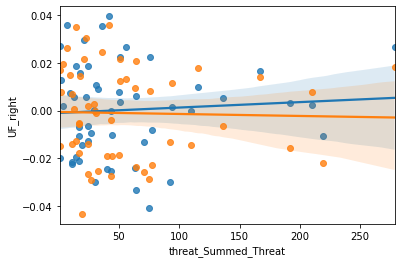

In [15]:
#Boxplots
sns.regplot(x=cleaned['threat_Summed_Threat'], y = cleaned['UF_left'])
sns.regplot(x=cleaned['threat_Summed_Threat'], y = cleaned['UF_right'])

<AxesSubplot:xlabel='sex', ylabel='UF_right'>

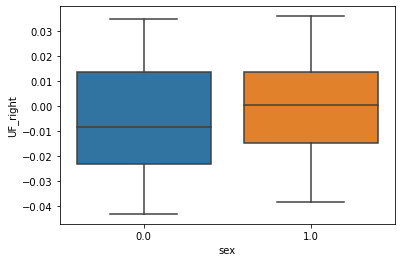

In [16]:
sns.boxplot(x=cleaned['sex'], y = cleaned['UF_right'])

### Demographics

Female: 1.0
Male: 0.0

In [17]:
grouped_df = bx_df.groupby('sex').count()
print("{}% Female; {}% Male".format(round(grouped_df['asr_age'][1]/len(bx_df)*100, 3), 
                                    round(grouped_df['asr_age'][0]/len(bx_df)*100, 3)))

66.265% Female; 33.735% Male


### CCA Analysis

Settled on 7 CCA components and 5 clusters using elbow plots

In [18]:
from sklearn.cross_decomposition import CCA
from sklearn.cluster import KMeans
import rcca
from cca_zoo import wrappers
from cca_zoo import data
from sklearn.model_selection import KFold, train_test_split

In [19]:
# Set input data, and train/test splits

sub_skf = bx_df['Subject']
in_xmat = binned_bx_mat
in_ymat = resid_fa_mat

#Train/test data
X_train, X_test, y_train, y_test = train_test_split(in_xmat, in_ymat, test_size=0.33, random_state=0)

In [20]:
# Settings

# The number of latent dimensions across models
latent_dims = 2
# The number of folds used for cross-validation/hyperparameter tuning
cv_folds = 3
# For running hyperparameter tuning in parallel (0 if not)
jobs = 2
# Number of iterations for iterative algorithms
max_iter = 10
# number of epochs for deep models
epochs = 50

In [21]:
### (Regularized) Generalized CCA via alternating least squares (can pass more than 2 views)
results = []

for i in range(2, 6):
    print('Trying {} components'.format(i))
    latent_dims = i
    ecca = wrappers.ElasticCCA(latent_dims=latent_dims, max_iter=max_iter,c=[0.0001,0.0001],l1_ratio=[0.1,0.1])
    ecca.fit(in_xmat, in_ymat)
    ecca_results = ecca.train_correlations
    results.append([i, ecca_results[0,1]])
    ecca_results = np.stack((ecca.train_correlations[0, 1], ecca.predict_corr(X_test, y_test)[0, 1]))
print(results)

Trying 2 components
Trying 3 components
Trying 4 components
Trying 5 components
[[2, array([0.80595315, 0.80533155])], [3, array([0.80596404, 0.8053124 , 0.54872034])], [4, array([0.80595716, 0.8053322 , 0.54858331, 0.61147788])], [5, array([0.80596151, 0.80532577, 0.54866959, 0.61142141, 0.56721026])]]


Text(0, 0.5, 'Correlation Coefficient')

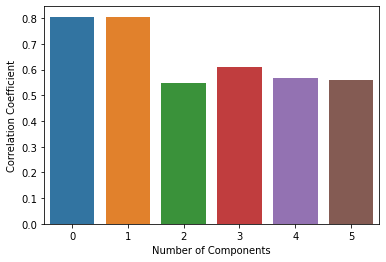

In [22]:
ecca_mainmodel = wrappers.ElasticCCA(latent_dims=6, max_iter=max_iter,c=[0.0001,0.0001],l1_ratio=[0.1,0.1])
ecca_mainmodel.fit(in_xmat, in_ymat)
res_real = ecca_mainmodel.train_correlations[0, 1]
res_real_df = pd.DataFrame(res_real).reset_index()
p = sns.barplot(x = res_real_df['index'], y = res_real_df[0])
p.set_xlabel('Number of Components')
p.set_ylabel('Correlation Coefficient')

In [23]:
# Compute null distribution with shuffled data
from sklearn.utils import resample
import copy

num_perm = 50
results = []
for i in range(0, num_perm):
    ecca_shuff = wrappers.ElasticCCA(latent_dims=6, max_iter=max_iter,c=[0.0001,0.0001],l1_ratio=[0.1,0.1])
    shuffled_xmat = resample(in_xmat, random_state = i, replace = False, n_samples = len(in_xmat))
    ecca_shuff.fit(shuffled_xmat, in_ymat)
    results.append(ecca_shuff.train_correlations[0, 1])


In [24]:
# Calculate permuted test results
for i in range(0, 6):
    real = res_real[i]
    shuff = pd.DataFrame(results).iloc[:,i].to_numpy()
    pval = len(np.where(shuff>=real)[0])/num_perm
    print('Component {}: p={}'.format(i, round(pval,3)))

Component 0: p=0.66
Component 1: p=0.04
Component 2: p=0.54
Component 3: p=0.22
Component 4: p=0.12
Component 5: p=0.06


Text(0.5, 1.0, 'Shuffled Results')

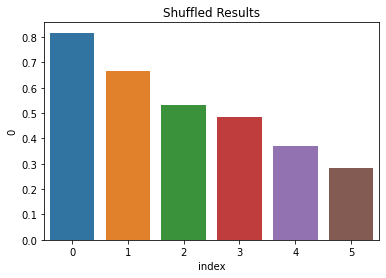

In [25]:
res = pd.DataFrame(results).mean(axis=0).transpose().reset_index()
p = sns.barplot(x = res['index'], y = res[0])
p.set_title('Shuffled Results')

In [26]:
# Examine associations
cca_X, cca_y = ecca_mainmodel.transform(in_xmat, in_ymat)
all_cca_XY = np.concatenate([cca_X, cca_y], axis=1)
cca_results = pd.DataFrame(all_cca_XY, columns = ['CCA_X1', 'CCA_X2', 'CCA_X3', 'CCA_X4',
                                                  'CCA_X5', 'CCA_X6', 'CCA_Y1', 'CCA_Y2', 'CCA_Y3',
                                                  'CCA_Y4', 'CCA_Y5', 'CCA_Y6'])
cca_resdf = pd.concat([bx_df['Subject'], cca_results], axis=1)
cca_mdf = pd.merge(resid_fa_df, cca_resdf, on = 'Subject')

In [27]:
# #Plot associations
# plt.figure(figsize=(10,8))
# sns.scatterplot(x="CCA_X5",
#                 y="UF_left", 
#                 hue="sex", data=cca_mdf)
# plt.title('First Pair of Canonical Covariates')

In [28]:
# # Examine in conjunction with other variables

# sns.boxplot(x="Species",
#                 y="CCX_1", 
#                data=cc_res)
# sns.stripplot(x="Species",
#                 y="CCX_1", 
#                  data=cc_res)

In [29]:
outputs = []
in_xmat = bx_mat_avg
in_ymat = resid_fa_mat
n_iters = 10

for i in range(1, n_iters):
    ecca_clust = wrappers.ElasticCCA(latent_dims=6, max_iter=max_iter,c=[0.0001,0.0001],l1_ratio=[0.1,0.1])
    ecca_clust.fit(in_xmat, in_ymat)
    res = pd.DataFrame(ecca_clust.train_correlations[0, 1]).reset_index()

    out_bx, out_dwi = ecca_clust.transform(in_xmat, in_ymat);
    all_data = np.concatenate([out_bx, out_dwi], axis=1)
        
#     for j in range(1, 20):
    cluster= KMeans(n_clusters = i, random_state=0)
    cluster.fit(all_data);
    outputs.append([i, cluster.inertia_])


In [30]:
elbow_df = pd.DataFrame(outputs, columns = ['i', 'inertia']).reset_index()

/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


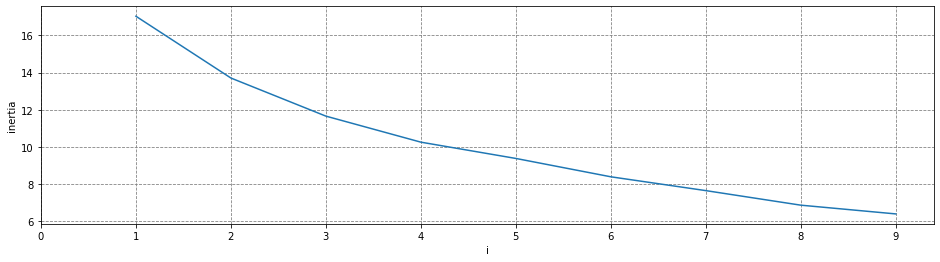

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
p1 = sns.lineplot(elbow_df['i'], elbow_df['inertia'])
plt.xticks(np.arange(0, n_iters, 1));
fig.set_size_inches(16, 4)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

In [32]:
from sklearn.cluster import SpectralClustering

# Final transformation
ecca = wrappers.ElasticCCA(latent_dims= 5, max_iter=max_iter,c=[0.0001,0.0001],l1_ratio=[0.1,0.1])
ecca.fit(in_xmat, in_ymat)
res = pd.DataFrame(ecca.train_correlations[0, 1]).reset_index()

out_bx, out_dwi = ecca.transform(in_xmat, in_ymat);
all_data = np.concatenate([out_bx, out_dwi], axis=1)

cluster= SpectralClustering(n_clusters = 3, random_state=1)
cluster.fit(all_data)

SpectralClustering(n_clusters=3, random_state=1)

In [33]:
#Add results to dataframe
res_df = bx_df
res_df['cluster_id'] = cluster.labels_
all_df1 = pd.merge(mean_fa, res_df, on = 'Subject', how = 'left')
all_df = pd.merge(all_df1, binned_bx_df, on = 'Subject')
print(all_df.shape)

#Separate by cluster
clust1 = all_df[all_df['cluster_id'] == 0]
clust2 = all_df[all_df['cluster_id'] == 1]
clust3 = all_df[all_df['cluster_id'] == 2]
clust4 = all_df[all_df['cluster_id'] == 3]
# clust5 = all_df[all_df['cluster_id'] == 4]

print(len(clust1))
print(len(clust2))
print(len(clust3))
print(len(clust4))


(83, 318)
62
8
13
0


In [34]:

from scipy.stats import ttest_ind
for i in range(0, 3):
    for j in range(0, 3):
        clusta = all_df[all_df['cluster_id'] == i]
        clustb = all_df[all_df['cluster_id'] == j]
        # Test diffs across stress
        r1, p1 = ttest_ind(clusta['Early Childhood Threat'], clustb['Early Childhood Threat'], nan_policy='omit')
        r2, p2 = ttest_ind(clusta['Middle Childhood Threat'], clustb['Middle Childhood Threat'], nan_policy='omit')
        r3, p3 = ttest_ind(clusta['Early Adolescence Threat'], clustb['Early Adolescence Threat'], nan_policy='omit')
        r4, p4 = ttest_ind(clusta['Late Adolescence Threat'], clustb['Late Adolescence Threat'], nan_policy='omit')
        
        r5, p5 = ttest_ind(clusta['Early Childhood Deprivation'], clustb['Early Childhood Deprivation'], nan_policy='omit')
        r6, p6 = ttest_ind(clusta['Middle Childhood Deprivation'], clustb['Middle Childhood Deprivation'], nan_policy='omit')
        r7, p7 = ttest_ind(clusta['Early Adolescence Deprivation'], clustb['Early Adolescence Deprivation'], nan_policy='omit')
        r8, p8 = ttest_ind(clusta['Late Adolescence Deprivation'], clustb['Late Adolescence Deprivation'], nan_policy='omit')
        
        #Test diffs across wm structure
        r9, p9 = ttest_ind(clusta['UF_right'], clustb['UF_right'])
        r10, p10 = ttest_ind(clusta['UF_left'], clustb['UF_left'])

        #Print results
        print('Cluster {} vs cluster {} Early Childhood Threat: {}, {}'.format(i, j,round(r1, 3), round(p1, 3)))
        print('Cluster {} vs cluster {} Middle Childhood Threat: {}, {}'.format(i, j,round(r2, 3), round(p2, 3)))
        print('Cluster {} vs cluster {} Adolescence Threat: {}, {}'.format(i, j,round(r3, 3), round(p3, 3)))
        print('Cluster {} vs cluster {} Teen Threat: {}, {}'.format(i, j,round(r4, 3), round(p4, 3)))
        
        print('Cluster {} vs cluster {} Early Childhood Dep: {}, {}'.format(i, j,round(r5, 3), round(p5, 3)))
        print('Cluster {} vs cluster {} Middle Childhood Dep: {}, {}'.format(i, j,round(r6, 3), round(p6, 3)))
        print('Cluster {} vs cluster {} Adolescence Dep: {}, {}'.format(i, j,round(r7, 3), round(p7, 3)))
        print('Cluster {} vs cluster {} Teen Dep: {}, {}'.format(i, j,round(r8, 3), round(p8, 3)))
        
        print('Cluster {} vs cluster {} LUF: {}, {}'.format(i, j,round(r9, 6), round(p9, 3)))
        print('Cluster {} vs cluster {} RUF: {}, {}'.format(i, j,round(r10, 6), round(p10, 3)))
        print('   ')
        print('   ')
        print('   ')

Cluster 0 vs cluster 0 Early Childhood Threat: 0.0, 1.0
Cluster 0 vs cluster 0 Middle Childhood Threat: 0.0, 1.0
Cluster 0 vs cluster 0 Adolescence Threat: 0.0, 1.0
Cluster 0 vs cluster 0 Teen Threat: 0.0, 1.0
Cluster 0 vs cluster 0 Early Childhood Dep: nan, nan
Cluster 0 vs cluster 0 Middle Childhood Dep: 0.0, 1.0
Cluster 0 vs cluster 0 Adolescence Dep: nan, nan
Cluster 0 vs cluster 0 Teen Dep: 0.0, 1.0
Cluster 0 vs cluster 0 LUF: 0.0, 1.0
Cluster 0 vs cluster 0 RUF: 0.0, 1.0
   
   
   
Cluster 0 vs cluster 1 Early Childhood Threat: -2.594, 0.012
Cluster 0 vs cluster 1 Middle Childhood Threat: -0.73, 0.468
Cluster 0 vs cluster 1 Adolescence Threat: -2.252, 0.028
Cluster 0 vs cluster 1 Teen Threat: -2.847, 0.006
Cluster 0 vs cluster 1 Early Childhood Dep: nan, nan
Cluster 0 vs cluster 1 Middle Childhood Dep: 0.357, 0.722
Cluster 0 vs cluster 1 Adolescence Dep: -6.925, 0.0
Cluster 0 vs cluster 1 Teen Dep: -4.983, 0.0
Cluster 0 vs cluster 1 LUF: 0.478714, 0.634
Cluster 0 vs cluster 1 RU

In [35]:
#Tract naming
tract_dict = {'AF_left':'Arcuate fascicle left',
              'AF_right':'Arcuate fascicle right',
              'ATR_left':'Anterior Thalamic Radiation left',
              'ATR_right':'Anterior Thalamic Radiation right',
              'CA':'Commissure Anterior',
              'CC_1':'Corpus Callosum Rostrum',
              'CC_2':'Corpus Callosum Genu',
              'CC_3':'Corpus Callosum Rostral body (Premotor)',
              'CC_4':'Corpus Callosum Anterior midbody (Primary Motor)',
              'CC_5':'Corpus Callosum Posterior midbody (Primary Somatosensory)',
              'CC_6':'Corpus Callosum Isthmus',
              'CC_7':'Corpus Callosum Splenium',
              'CG_left':'Cingulum left',
              'CG_right':'Cingulum right',
              'CST_left':'Corticospinal tract left',
              'CST_right':'Corticospinal tract right',
              'MLF_left': 'Middle longitudinal fascicle left',
              'MLF_right':'Middle longitudinal fascicle right',
              'FPT_left':'Fronto-pontine tract left',
              'FPT_right':'Fronto-pontine tract right',
              'FX_left':'Fornix left',
              'FX_right':'Fornix right',
              'ICP_left':'Inferior cerebellar peduncle left',
              'ICP_right':'Inferior cerebellar peduncle right',
              'IFO_left':'Inferior occipito-frontal fascicle left', 
              'IFO_right':'Inferior occipito-frontal fascicle right', 
              'ILF_left':'Inferior longitudinal fascicle left',
              'ILF_right':'Inferior longitudinal fascicle right',
              'MCP':'Middle cerebellar peduncle',
              'OR_left': 'Optic radiation left', 
              'OR_right': 'Optic radiation right', 
              'POPT_left': 'Parieto‐occipital pontine left',
              'POPT_right':'Parieto‐occipital pontine right',
              'SCP_left':'Superior cerebellar peduncle left',
              'SCP_right':'Superior cerebellar peduncle right',
              'SLF_I_left':'Superior longitudinal fascicle I left',
              'SLF_I_right':'Superior longitudinal fascicle I right',
              'SLF_II_left':'Superior longitudinal fascicle II left',
              'SLF_II_right':'Superior longitudinal fascicle II right',
              'SLF_III_left': 'Superior longitudinal fascicle III left',
              'SLF_III_right':'Superior longitudinal fascicle III right',
              'STR_left':'Superior Thalamic Radiation left',
              'STR_right':'Superior Thalamic Radiation right',
              'UF_left': 'Uncinate fascicle left',
              'UF_right': 'Uncinate fascicle right',
              'CC':'Corpus Callosum - all',
              'T_PREF_left':'Thalamo-prefrontal left',
              'T_PREF_right':'Thalamo-prefrontal right',
              'T_PREM_left':'Thalamo-premotor left',
              'T_PREM_right':'Thalamo-premotor right',
              'T_PREC_left':'Thalamo-precentral left',
              'T_PREC_right':'Thalamo-precentral right',
              'T_POSTC_left':'Thalamo-postcentral left',
              'T_POSTC_right':'Thalamo-postcentral right',
              'T_PAR_left':'Thalamo-parietal left',
              'T_PAR_right':'Thalamo-parietal right',
              'T_OCC_left':'Thalamo-occipital left',
              'T_OCC_right':'Thalamo-occipital right',
              'ST_FO_left':'Striato-fronto-orbital left',
              'ST_FO_right':'Striato-fronto-orbital right',
              'ST_PREF_left':'Striato-prefrontal left',
              'ST_PREF_right':'Striato-prefrontal right',
              'ST_PREM_left':'Striato-premotor left',
              'ST_PREM_right':'Striato-premotor right',
              'ST_PREC_left':'Striato-precentral left',
              'ST_PREC_right':'Striato-precentral right',
              'ST_POSTC_left':'Striato-postcentral left',
              'ST_POSTC_right':'Striato-postcentral right',
              'ST_PAR_left':'Striato-parietal left',
              'ST_PAR_right':'Striato-parietal right',
              'ST_OCC_left':'Striato-occipital left',
              'ST_OCC_right':'Striato-occipital right'}

tract_dict_nohems = copy.deepcopy(tract_dict)
for key, value in tract_dict_nohems.items():
    # Remove left/right
    tract_dict_nohems[key] = value.replace('left','').replace('right','')

In [72]:
# Spider Plots

# Stress DF
spider_df = all_df.loc[:,'Early Childhood Threat':'Late Adolescence Deprivation']
spider_df['Group'] = all_df['cluster_id']
spider_df['Group'] = spider_df['Group'] +1
spider_df_grouped = pd.melt(spider_df, id_vars = 'Group', var_name = 'Exposure', value_name = 'Value')
spider_plottingdf = spider_df_grouped.groupby(['Exposure', 'Group']).mean().reset_index()

# DWI DF
spider_dwi = resid_fa_df.drop('Subject', axis=1)
spider_dwi['Group'] = all_df['cluster_id']

#Replace column names
spider_dwi.shape
newcols = pd.Series(spider_dwi.columns).replace(tract_dict)
spider_dwi.columns = newcols
spider_dwi['Group'] = spider_dwi['Group'] +1
plot_dwi = spider_dwi.melt(id_vars = 'Group', var_name = 'Tract', value_name = 'Value')
dwi_plottingdf = plot_dwi.groupby(['Tract', 'Group']).mean().reset_index()

#Split into LR hemis
hemi = []
for i in range(0, len(dwi_plottingdf)):
    x =  dwi_plottingdf['Tract'][i]
    hemi.append(x.split(' ')[-1])
    
dwi_plottingdf['Hemi'] = hemi
left_plottingdf = dwi_plottingdf[dwi_plottingdf['Hemi'] == 'left']
right_plottingdf = dwi_plottingdf[dwi_plottingdf['Hemi'] == 'right']
center_plottingdf = dwi_plottingdf[dwi_plottingdf['Hemi'] != 'right']
center_plottingdf = center_plottingdf[center_plottingdf['Hemi'] != 'left']

#All; separate into clusters
clust_plot1 = spider_plottingdf[spider_plottingdf['Group'] == 0] #.reindex([6, 10, 2, 14, 4, 8, 0, 12])
clust_plot2 = spider_plottingdf[spider_plottingdf['Group'] == 1] #.reindex([7, 11, 3, 15, 5, 9, 1, 13])
clust_plot3 = spider_plottingdf[spider_plottingdf['Group'] == 2] #.reindex([8, 12, 4, 16, 6, 10, 2, 14])

dwi_plot1 = dwi_plottingdf[dwi_plottingdf['Group'] == 0] #.reindex([6, 10, 2, 14, 4, 8, 0, 12])
dwi_plot2 = dwi_plottingdf[dwi_plottingdf['Group'] == 1] #.reindex([7, 11, 3, 15, 5, 9, 1, 13])
dwi_plot3 = dwi_plottingdf[dwi_plottingdf['Group'] == 2] #.reindex([8, 12, 4, 16, 6, 10, 2, 14])

In [68]:
# Anova to test diffs in tracts
from scipy.stats import f_oneway

g1 = spider_dwi[spider_dwi['Group'] == 1].drop('Group', axis=1).to_numpy()
g2 = spider_dwi[spider_dwi['Group'] == 2].drop('Group', axis=1).to_numpy()
g3 = spider_dwi[spider_dwi['Group'] == 3].drop('Group', axis=1).to_numpy()

dwistat, dwip = f_oneway(g1, g2, g3, axis=0)

gs1 = spider_df[spider_df['Group'] == 1].drop('Group', axis=1).to_numpy()
gs2 = spider_df[spider_df['Group'] == 2].drop('Group', axis=1).to_numpy()
gs3 = spider_df[spider_df['Group'] == 3].drop('Group', axis=1).to_numpy()

stressstat, stressp = f_oneway(gs1, gs2, gs3, axis=0)

In [69]:
anova_res_dwi = pd.DataFrame(dwistat, index = spider_dwi.columns[0:50], columns = ['f-stat'])
anova_res_dwi['p-value'] = dwip
anova_res_dwi['fdr-corrected'] = fdrcorr(anova_res_dwi['p-value'].T, alpha=0.05, method='indep', is_sorted=False)[1]
anova_res_dwi[anova_res_dwi['p-value'] < 0.051].sort_values(by='fdr-corrected')

# anova_res_stress = pd.DataFrame(stressstat, index = spider_df.columns[0:8], columns = ['f-stat'])
# anova_res_stress['p-value'] = stressp
# anova_res_stress['fdr-corrected'] = fdrcorr(anova_res_stress['p-value'].T, alpha=0.05, method='indep', is_sorted=False)[1]
# anova_res_stress[anova_res_stress['p-value'] < 0.051]

,f-stat,p-value,fdr-corrected
Fronto-pontine tract left,8.085075,0.000634,0.031693
Cingulum right,7.247361,0.001280,0.032006
Corticospinal tract left,5.149952,0.007872,0.082441
Superior cerebellar peduncle right,5.315986,0.006797,0.082441
Thalamo-premotor left,5.097909,0.008244,0.082441
Thalamo-parietal right,4.499412,0.014068,0.117232
Anterior Thalamic Radiation left,3.925795,0.023638,0.168844
Anterior Thalamic Radiation right,3.778982,0.027025,0.168909
Parieto‐occipital pontine right,3.476378,0.035667,0.187341
Thalamo-premotor right,3.319518,0.041215,0.187341


In [79]:
spider_plottingdf = spider_plottingdf.reindex([6, 7, 8, 9, 10, 11,
                                               18, 19, 20, 21, 22, 23, 
                                               0, 1, 2, 3, 4, 5, 
                                               12, 13, 14, 15,16, 17]).reset_index().drop('index', axis=1)

In [80]:
# Spider Plots
import plotly.express as px

fig = px.line_polar(spider_plottingdf, r='Value', theta="Exposure", color="Group", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()


In [40]:
# Spider Plots
import plotly.graph_objects as go

left_plottingdf['Tract'] = left_plottingdf['Tract'].str.replace('left', '').str.replace('tract', '')

fig = px.line_polar(left_plottingdf, r='Value', theta="Tract", color="Group", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Safe, range_r=[-0.025, 0.025])
fig.update_polars(radialaxis_tickangle=45)
# fig.update_polars(angularaxis_rotation=45)
# fig.update_polars(angularaxis_uirevision=45)
# fig.update_polars(angularaxis_tickangle=45)
fig.show()


/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
# Spider Plots
import plotly.graph_objects as go
right_plottingdf['Tract'] = right_plottingdf['Tract'].str.replace('right', '').str.replace('tract', '')
fig = px.line_polar(right_plottingdf, r='Value', theta="Tract", color="Group", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Safe, range_r=[-0.025, 0.025])
fig.update_polars(radialaxis_tickangle=45)
# fig.update_polars(angularaxis_rotation=45)
# fig.update_polars(angularaxis_uirevision=45)
# fig.update_polars(angularaxis_tickangle=45)
fig.show()


/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
# Spider Plots
import plotly.graph_objects as go

fig = px.line_polar(center_plottingdf, r='Value', theta="Tract", color="Group", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Safe, range_r=[-0.025, 0.025])
fig.update_polars(radialaxis_tickangle=45)
# fig.update_polars(angularaxis_rotation=45)
# fig.update_polars(angularaxis_uirevision=45)
# fig.update_polars(angularaxis_tickangle=45)
fig.show()


In [43]:
# long_df = pd.melt(resid_df, id_vars = 'Subject', var_name = 'Tract', value_name = 'Value')
# plotdf_long = pd.merge(long_df, all_df)
# plotdf_wide = pd.merge(resid_df, all_df)

# #RI long df
# long_clust = pd.merge(ri_data_avg, all_df[['Subject', 'cluster_id']], how='right')
# threat_clust = long_clust[['Subject', 'cluster_id', 'threat_avg_sev', 'threat_avg_sev.1', 'threat_avg_sev.2',
#        'threat_avg_sev.3', 'threat_avg_sev.4', 'threat_avg_sev.5',
#        'threat_avg_sev.6', 'threat_avg_sev.7', 'threat_avg_sev.8',
#        'threat_avg_sev.9', 'threat_avg_sev.10', 'threat_avg_sev.11',
#        'threat_avg_sev.12', 'threat_avg_sev.13', 'threat_avg_sev.14',
#        'threat_avg_sev.15', 'threat_avg_sev.16', 'threat_avg_sev.17',
#        'threat_avg_sev.18', 'threat_avg_sev.19', 'threat_avg_sev.20',
#        'threat_avg_sev.21', 'threat_avg_sev.22', 'threat_avg_sev.23',
#        'threat_avg_sev.24', 'threat_avg_sev.25', 'threat_avg_sev.26',
#        'threat_avg_sev.27', 'threat_avg_sev.28', 'threat_avg_sev.29']]

# thr_columns = ['Subject', 'cluster_id', 'Age 0', 'Age 1', 'Age 2', 'Age 3',
#        'Age 4', 'Age 5', 'Age 6', 'Age 7', 'Age 8', 'Age 9', 'Age 10', 'Age 11',
#        'Age 12', 'Age 13', 'Age 14', 'Age 15',
#        'Age 16', 'Age 17', 'Age 18', 'Age 19',
#        'Age 20', 'Age 21', 'Age 22', 'Age 23',
#        'Age 24', 'Age 25', 'Age 26', 'Age 27', 'Age 28', 'Age 29']
# threat_clust.columns = thr_columns

# dep_clust = long_clust[['Subject', 'cluster_id', 'dep_avg_sev', 'dep_avg_sev.1', 'dep_avg_sev.2', 'dep_avg_sev.3',
#        'dep_avg_sev.4', 'dep_avg_sev.5', 'dep_avg_sev.6', 'dep_avg_sev.7',
#        'dep_avg_sev.8', 'dep_avg_sev.9', 'dep_avg_sev.10', 'dep_avg_sev.11',
#        'dep_avg_sev.12', 'dep_avg_sev.13', 'dep_avg_sev.14', 'dep_avg_sev.15',
#        'dep_avg_sev.16', 'dep_avg_sev.17', 'dep_avg_sev.18', 'dep_avg_sev.19',
#        'dep_avg_sev.20', 'dep_avg_sev.21', 'dep_avg_sev.22', 'dep_avg_sev.23']]

# dep_columns = ['Subject', 'cluster_id', 'Age 0', 'Age 1', 'Age 2', 'Age 3',
#        'Age 4', 'Age 5', 'Age 6', 'Age 7', 'Age 8', 'Age 9', 'Age 10', 'Age 11',
#        'Age 12', 'Age 13', 'Age 14', 'Age 15',
#        'Age 16', 'Age 17', 'Age 18', 'Age 19',
#        'Age 20', 'Age 21', 'Age 22', 'Age 23']
# dep_clust.columns = dep_columns

# thr_long = pd.melt(threat_clust, id_vars = ['Subject', 'cluster_id'], var_name = 'Age of Exposure', value_name = 'Number of Exposures')
# dep_long = pd.melt(dep_clust, id_vars = ['Subject', 'cluster_id'], var_name = 'Age of Exposure', value_name = 'Number of Exposures')

# #Separate into clusters
# thr_long_clust1 = thr_long[thr_long['cluster_id'] == 0]
# dep_long_clust1 = dep_long[dep_long['cluster_id'] == 0]

# thr_long_clust2 = thr_long[thr_long['cluster_id'] == 1]
# dep_long_clust2 = dep_long[dep_long['cluster_id'] == 1]

# thr_long_clust3 = thr_long[thr_long['cluster_id'] == 2]
# dep_long_clust3 = dep_long[dep_long['cluster_id'] == 2]

In [44]:
# import matplotlib.pyplot as plt
# fig, [ax1, ax2] = plt.subplots(2, 1)
# fig.set_size_inches(16, 10);
# ax1 = sns.barplot(x = thr_long_clust1['Age of Exposure'], y = thr_long_clust1['Number of Exposures'],
#                  ax = ax1)
# xlabels = ax1.get_xticklabels();
# ax1.set_xticklabels(xlabels, rotation=45);
# ax1.set_yticks(range(0, 30, 5));
# ax1.set_title('Experiences of Threat Across Cluster 1')

# ax2 = sns.barplot(x = thr_long_clust2['Age of Exposure'], y = thr_long_clust2['Number of Exposures'],
#                  ax=ax2)
# xlabels = ax2.get_xticklabels();
# ax2.set_xticklabels(xlabels, rotation=45);
# ax2.set_yticks(range(0, 30, 5));
# ax2.set_title('Experiences of Threat Across Cluster 2')
# fig.tight_layout()

# # ax3 = sns.barplot(x = thr_long_clust3['Age of Exposure'], y = thr_long_clust3['Number of Exposures'],
# #                  ax=ax3)
# # xlabels = ax3.get_xticklabels();
# # ax3.set_xticklabels(xlabels, rotation=45);
# # ax3.set_yticks(range(0, 30, 5));
# # ax3.set_title('Experiences of Threat Across Cluster 3')
# # fig.tight_layout()

In [45]:
# import matplotlib.pyplot as plt
# fig, [ax1, ax2] = plt.subplots(2, 1)
# fig.set_size_inches(16, 10);
# xlabels = ax.get_xticklabels();
# ax1 = sns.barplot(x = dep_long_clust1['Age of Exposure'], y = dep_long_clust1['Number of Exposures'],
#                  ax = ax1)
# xlabels = ax1.get_xticklabels();
# ax1.set_xticklabels(xlabels, rotation=45);
# ax1.set_yticks(range(0, 30, 5))
# ax1.set_title('Experiences of Deprivation Across Cluster 1')

# ax2 = sns.barplot(x = dep_long_clust2['Age of Exposure'], y = dep_long_clust2['Number of Exposures'],
#                  ax=ax2)
# xlabels = ax2.get_xticklabels();
# ax2.set_yticks(range(0, 30, 5)) 
# ax2.set_xticklabels(xlabels, rotation=45);
# fig.tight_layout()
# ax2.set_title('Experiences of Deprivation Across Cluster 2')

# # ax3 = sns.barplot(x = dep_long_clust3['Age of Exposure'], y = dep_long_clust2['Number of Exposures'],
# #                  ax=ax3)
# # xlabels = ax2.get_xticklabels();
# # ax3.set_yticks(range(0, 30, 5)) 
# # ax3.set_xticklabels(xlabels, rotation=45);
# # fig.tight_layout()
# # ax3.set_title('Experiences of Deprivation Across Cluster 3')

### OLS/LME Analysis

In [46]:
yvar = 'UF_left'
# long_thr_df_dwi

In [47]:
lme_mod = sm.MixedLM.from_formula("{} ~ threat_Summed_Threat * sex + asr_age + sex + diagnostic_group".format(yvar), 
                                 re_formula="1", 
                groups="Subject", data=plotdf_wide.replace(np.nan, 0))
results = lme_mod.fit()
print(results.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     UF_left 
No. Observations:      83          Method:                 REML    
No. Groups:            83          Scale:                  0.0002  
Min. group size:       1           Log-Likelihood:         166.5192
Max. group size:       1           Converged:              Yes     
Mean group size:       1.0                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.012    0.006 -1.883 0.060 -0.024  0.000
threat_Summed_Threat     -0.000    0.000 -0.030 0.976 -0.000  0.000
sex                      -0.000    0.006 -0.040 0.968 -0.011  0.011
threat_Summed_Threat:sex  0.000    0.000  0.354 0.723 -0.000  0.000
asr_age                   0.000    0.000  1.139 0.255 -0.000  0

/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



In [48]:
regressors = bx_df[['asr_age', 'sex', 'diagnostic_group', 'all_Summed_All']].replace(np.nan, 0)
model = sm.OLS(endog = right_uf, exog=regressors)
result = model.fit()
print(result.summary())

NameError: name 'right_uf' is not defined

### Ridge Regression Analysis

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

def perform_cv(subids, neural_data, bx_data):
    numbers1 = pd.Series(range(0, len(neural_data))).to_numpy()
    reg_corr = []
    reg_p = []
    r2 = []
    for i in range(0, 50):
        X_train, X_test, y_train, y_test = train_test_split(neural_data, bx_data, test_size=0.33, random_state=i)

        # Train the model 
        regression = Ridge(normalize = True, alpha=1.0)
        regfit = regression.fit(X_train, y_train)

        # Test the model
        score = regfit.predict(X_test)
        corr, p = spearmanr(score, y_test)
        reg_corr.append(corr)
        reg_p.append(p)
        print('Correlation between train and test: {}'.format(corr))
        print('P-value: {}'.format(p))
        score = regfit.score(X_test, y_test)
        r2.append(score)
    return reg_corr, reg_p, r2